In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *

2024-08-06 11:32:39.519315: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 11:32:39.955924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd
import glob
import os

In [4]:
def read_csv_files_into_dataframe(folder_path):
    # Use glob to find all CSV files in the specified folder
    csv_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    # Read each CSV file into a list of DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]
    
    # Concatenate all DataFrames into a single DataFrame
    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return combined_dataframe

In [5]:
folder_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/results_BGMMFit_20240730'

combined_df = read_csv_files_into_dataframe(folder_path)

In [6]:
num_temp = [2, 5, 10, 50, 100]
mse_loss_array = []
for iter in tqdm(range(100)):
    mse_loss_list = []
    for i in num_temp:
        rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
        rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
        assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
        mse_loss = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
        mse_loss_list.append(mse_loss)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 100)
kl_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
    kl_loss_array.append(kl_loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
mse_loss_mean = np.mean(mse_loss_array, axis=0)
kl_loss_mean = np.mean(kl_loss_array, axis=0)

In [12]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240806/'

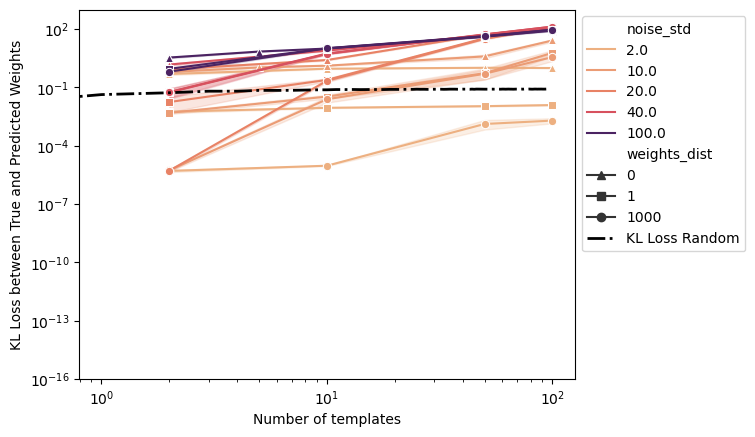

In [13]:
conditions = (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='weight_kl', hue='noise_std', style='weights_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])

sns.lineplot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

plt.yscale('log')
plt.xscale('log')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.ylim([1e-16, 1e3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'kl_weights_num_templates_combined.png', dpi=300, bbox_inches='tight')

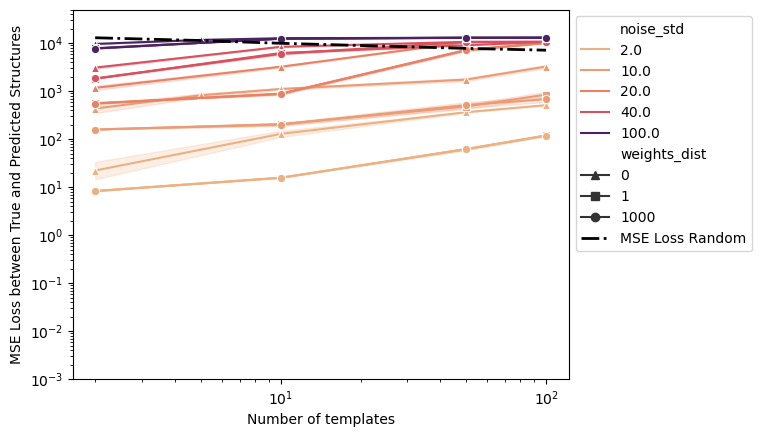

In [14]:
num_temp = [2, 5, 10, 50, 100]
conditions = (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='mean_mse', hue='noise_std', style='weights_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])
plt.plot(num_temp, mse_loss_mean, label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')

plt.xscale('log')
plt.yscale('log')

p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.ylim([1e-3, 5e4])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'mean_mse_num_templates_combined.png', dpi=300, bbox_inches='tight')